# Time series - Sparse representation Coding

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.decomposition import DictionaryLearning

Basic implementation of sparse signal

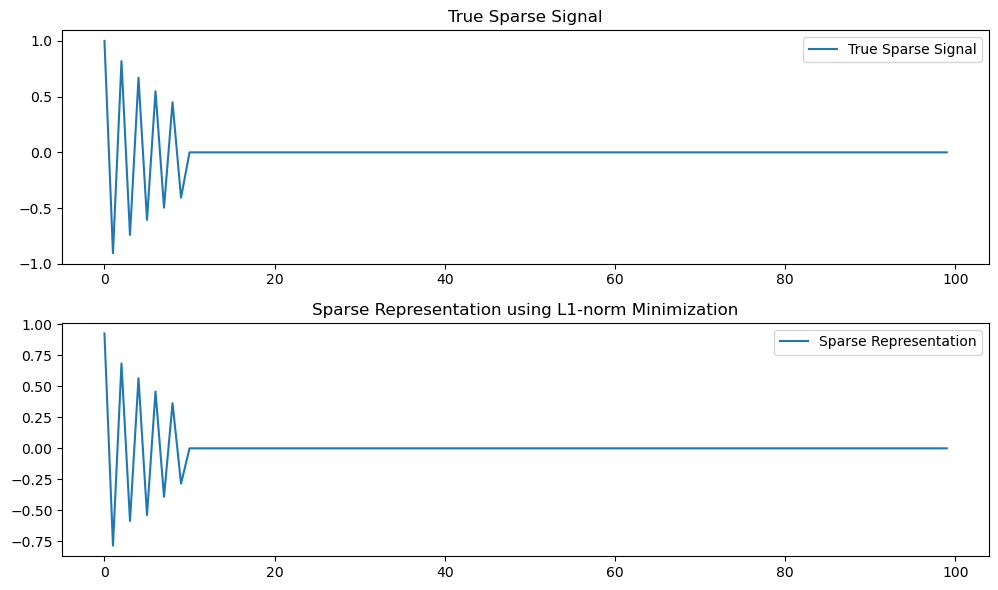

In [14]:
np.random.seed(42)
n_samples, n_features = 200, 100
X = np.random.randn(n_samples, n_features)
idx = np.arange(n_features)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0
X_sparse = X.dot(coef)

noise_level = 0.1
X_noisy = X_sparse + noise_level * np.random.normal(size=n_samples)

alpha = 0.1
lasso = Lasso(alpha=alpha)
lasso.fit(X, X_noisy)
sparse_coef = lasso.coef_

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(coef, label='True Sparse Signal')
plt.title('True Sparse Signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sparse_coef, label='Sparse Representation')
plt.title('Sparse Representation using L1-norm Minimization')
plt.legend()

plt.tight_layout()
plt.show()

FTS-SRC

The Dictionary Matrix D N*K can the sparse representation of the original signal X = D * $\alpha$


A optimisation problme to be solved by a pursuit algorithm or the orthogonal matching pursuit

Sparsity level \tau



**Matching pursuit using known atoms**

/tmp/ipykernel_36904/1757967175.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  reconstructed_signal = np.sum(coef * atom for coef, atom in zip(coefficients, dictionary))


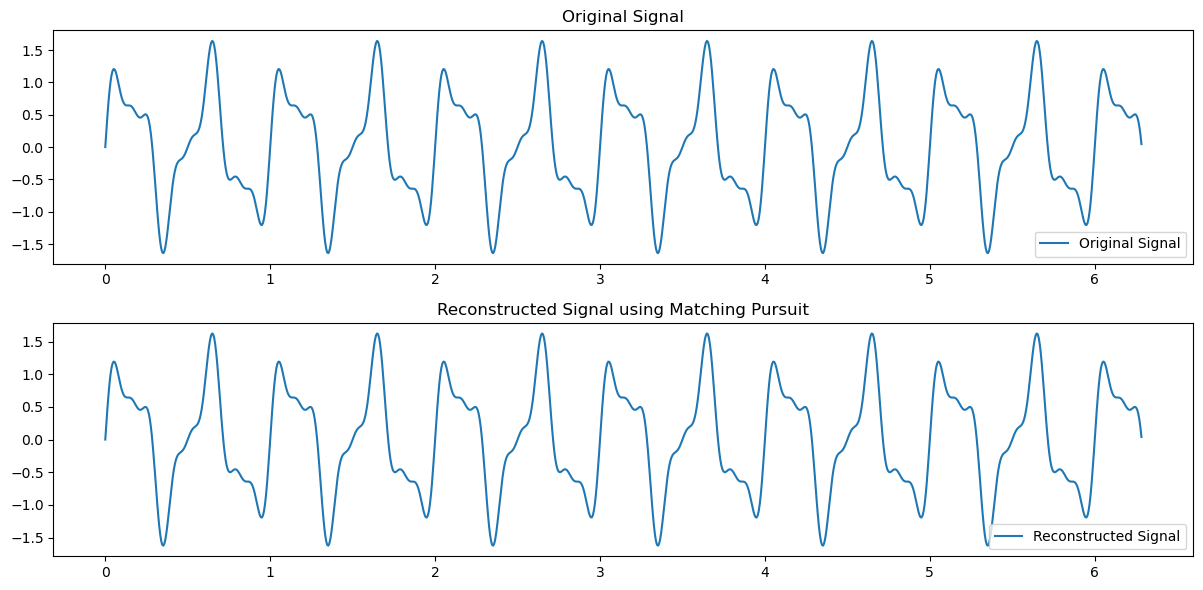

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def matching_pursuit(signal, dictionary, max_iterations=100):
    coefficients = []  # Store coefficients for each atom
    residual = signal.copy()  # Initial residual is the input signal

    for _ in range(max_iterations):
        # Calculate inner product of each atom with the current residual
        inner_products = [np.abs(np.dot(residual, atom)) for atom in dictionary]

        # Select the atom with the maximum inner product
        selected_atom_index = np.argmax(inner_products)
        selected_atom = dictionary[selected_atom_index]

        # Calculate and store the coefficient for the selected atom
        coefficient = np.dot(signal, selected_atom) / np.dot(selected_atom, selected_atom)
        coefficients.append(coefficient)

        # Update the residual
        residual -= coefficient * selected_atom

    return coefficients

t = np.linspace(0, 2*np.pi, 1000)
signal = np.sin(2*np.pi*2*t) + 0.5*np.sin(2*np.pi*5*t) + 0.2*np.sin(2*np.pi*8*t)
dictionary = [np.sin(2*np.pi*2*t), np.sin(2*np.pi*5*t), np.sin(2*np.pi*8*t)]
coefficients = matching_pursuit(signal, dictionary)
reconstructed_signal = np.sum(coef * atom for coef, atom in zip(coefficients, dictionary))
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_signal, label='Reconstructed Signal')
plt.title('Reconstructed Signal using Matching Pursuit')
plt.legend()

plt.tight_layout()
plt.show()

Dictionary learning without knowing atoms using skilearn

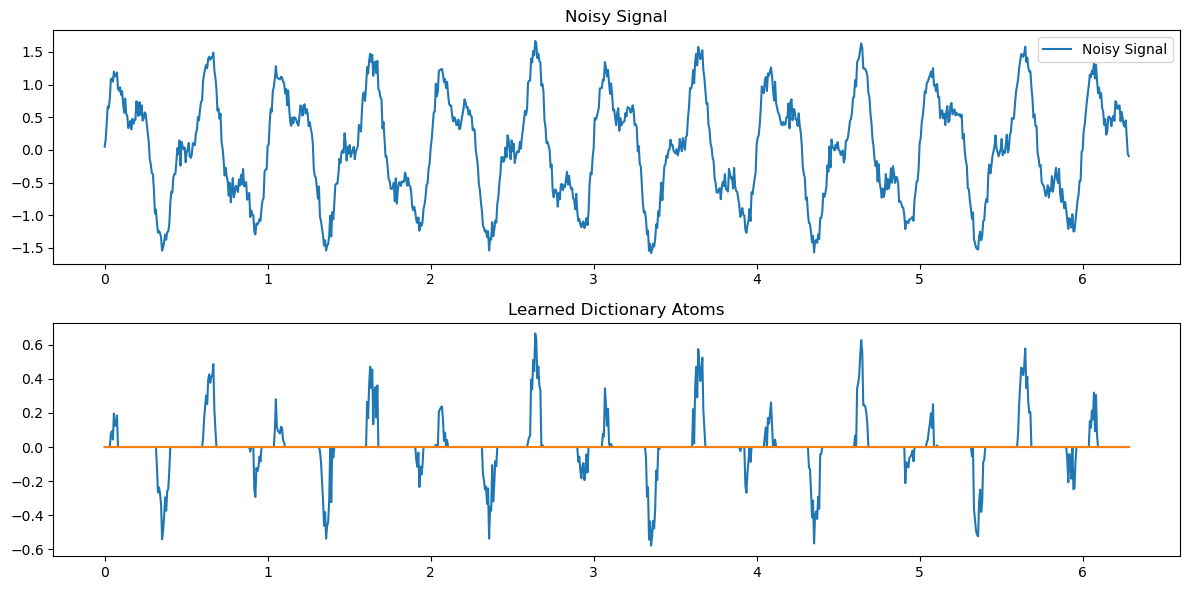

In [4]:
# Demo

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning

t = np.linspace(0, 2*np.pi, 1000)
signal = np.sin(2*np.pi*2*t) + 0.5*np.sin(2*np.pi*5*t)

np.random.seed(42)
noise = 0.1 * np.random.normal(size=len(signal))
noisy_signal = signal + noise

data = np.reshape(noisy_signal, (1, -1)).T

n_atoms = 2
dl = DictionaryLearning(n_atoms)
learned_dictionary = dl.fit_transform(data).T
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.title('Noisy Signal')
plt.legend()

plt.subplot(2, 1, 2)
for atom in learned_dictionary:
    plt.plot(t, atom)
plt.title('Learned Dictionary Atoms')

plt.tight_layout()
plt.show()


In [20]:
# Implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd

def generate_random_data(num_samples, timesteps):
    data_matrix = np.zeros((timesteps, num_samples))

    for i in range(num_samples):
        signal = np.sin(2 * np.pi * np.random.uniform(1, 10) * np.linspace(0, 2*np.pi, timesteps))
        noise = 0.1 * np.random.normal(size=timesteps)
        noisy_signal = signal + noise
        data_matrix[:, i] = noisy_signal

    return data_matrix

def custom_scorer(y_true, y_pred):
    return -np.mean((y_true - y_pred) ** 2)

# 列着排有问题
def create_sliding_windows(data, window_size, stride):
    num_samples = len(data)
    num_windows = ((num_samples - window_size) // stride) + 1
    X_matrix = np.zeros((window_size, num_windows))

    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        window = data[start:end]
        X_matrix[:, i] = window.T

    return X_matrix

def read_csv_and_preprocess(file_path, data_type_mapping, column_mapping=None):
    try:
        # Read CSV file to DataFrame with date parsing
        df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
        if column_mapping:
            df = df.rename(columns=column_mapping)
        # Process 'Vol.' column
        df['Volume'] = df['Volume'].str.replace('M', '').astype(float)
        df['Change_Percentage'] = df['Change_Percentage'].str.replace('%', '').astype(float)
        numeric_columns = ['Price', 'Open', 'High', 'Low']
        df[numeric_columns] = df[numeric_columns].replace(',', '', regex=True).astype(float)
        df = df.astype(data_type_mapping)
        print("Successfully read the CSV file and preprocessed the DataFrame.")
        return df

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None


# def find_best_params(X, param_grid, transform_algorithm='omp', cv=5, random_state=None):
#     """
#     Find the best parameters for Dictionary Learning using GridSearchCV.

#     Parameters:
#     - X: Input data matrix.
#     - param_grid: Dictionary specifying the parameters to search, e.g., {'n_components': [5, 10, 15], 'transform_alpha': [0.01, 0.1, 1.0]}.
#     - transform_algorithm: Algorithm used for sparse coding, default is 'lasso_lars'.
#     - cv: Number of cross-validation folds, default is 5.
#     - random_state: Random seed for reproducibility, default is None.

#     Returns:
#     - best_params: Dictionary containing the best parameters found.
#     """

#     # Create DictionaryLearning model
#     dict_learner = DictionaryLearning(transform_algorithm=transform_algorithm, random_state=random_state)
#     grid_search = GridSearchCV(dict_learner, param_grid=param_grid, cv=cv)
#     grid_search.fit(X)

#     # Get the best parameters
#     best_params = grid_search.best_params_

#     return best_params


# num_samples = 5
# timesteps = 50  
# random_data_matrix = generate_random_data(num_samples, timesteps)
# plt.figure(figsize=(12, 6))
# for i in range(num_samples):
#     plt.plot(random_data_matrix[:, i], label=f'Series {i + 1}')

# plt.title('Generated Random Time Series Data')
# plt.legend()
# plt.show()

# flattened_data = np.reshape(random_data_matrix, (timesteps, -1))

# print("Shape of Flattened Data Matrix:", flattened_data.shape)


Learn the dictionary

In [21]:
# A demo

num_samples = 5
timesteps = 50  
n_components = 5
transform_alpha = 0.01
tol = 1e-8
max_iter = 1000

random_data_matrix = generate_random_data(num_samples, timesteps).T
(N,J) = random_data_matrix.shape

dl = DictionaryLearning(n_components = n_components, tol=tol, max_iter = max_iter, transform_alpha=transform_alpha)
learned_dictionary = dl.fit_transform(random_data_matrix) # Number samples* Number features


Read the data and learn from it

In [27]:
window_size = 5
stride = 2
timesteps = 50  
n_components = 15  # key component size
transform_alpha = 0.01
tol = 1e-8
max_iter = 1000
delta = 0.8
tau = 5

csv_file_path = "../Data/Dow Jones Industrial Average Historical Data - Daily.csv"
data_type_mapping = {
    'Date': 'datetime64[ns]',
    'Price': 'float64',
    'Open': 'float64',
    'High': 'float64',
    'Low': 'float64',
    'Volume': 'float64',
    'Change_Percentage': 'float64',
}
column_mapping = {
    'Vol.': 'Volume',
    'Change %': 'Change_Percentage',
}

# True data
# data_time_series = read_csv_and_preprocess(csv_file_path, data_type_mapping, column_mapping)
# price_series = data_time_series["Price"].values

# Simulation data
np.random.seed(42)
price_series = np.random.uniform(100, 200, 200)


N = price_series.size
N_H = int(delta*price_series.size)
N_T = N - N_H
price_series_H = price_series[:N_H]
price_series_T = price_series[N_H:]

# X_H_matrix = create_sliding_windows(price_series_H, window_size, stride)
# X_T_matrix = create_sliding_windows(price_series_T, window_size, stride)


In [ ]:
# random_data_matrix = generate_random_data(num_samples, timesteps).T
# (N,J) = random_data_matrix.shape
# dl = DictionaryLearning(n_components = n_components, tol=tol, max_iter = max_iter, transform_alpha=transform_alpha)
# A_H = dl.fit_transform(X_H_matrix) # Number samples* Number features K * C1
# learned_dictionary = dl.components_ # n_components, n_features W * C1

In [28]:
import numpy as np
from scipy.optimize import minimize

# 稀疏性的权衡问题
def dictionary_learning(X, w, s, K, t):
    """
    Perform dictionary learning on the input time series X.
    """
    windows = create_sliding_windows(X, w, s)
    c_prime = windows.shape[1]
    
    # Initialize dictionary and coefficients
    D = np.random.rand(w, K)
    A = np.random.rand(K, c_prime)

    def objective(params):
        D = params[:w * K].reshape((w, K))
        A = params[w * K:].reshape((K, c_prime))
        return np.linalg.norm(windows - np.dot(D, A), 'fro')**2

    def sparsity_constraint(A):
        return np.sum(np.abs(A) > 1e-5) - t
    
    def combined_objective(params):
        D = params[:w * K].reshape((w, K))
        A = params[w * K:].reshape((K, c_prime))
        return objective(params) + sparsity_constraint(A)

    result = minimize(combined_objective, np.concatenate((D.flatten(), A.flatten())))

    # Retrieve the learned dictionary
    learned_D = result.x[:w * K].reshape((w, K))
    sparse_A = result.x[w * K:].reshape((K, c_prime))
    return learned_D,sparse_A

w = 10  # window size
s = 2   # step size
K = 20  # number of atoms in the dictionary
t = 5   # sparsity level

learned_dictionary,sparse_A = dictionary_learning(price_series_H, w, s, K, t)

In [37]:
import pickle
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'dictionary_learning_objects_{timestamp}.pkl'

# Decomment it if want to save
with open(file_name, 'wb') as file:
    pickle.dump({'A_H': sparse_A, 'learned_dictionary': learned_dictionary, 'timestamp': timestamp}, file)
print(f"Objects saved to file: {file_name}")

Objects saved to file: dictionary_learning_objects_20240106_002516.pkl


In [38]:
try:
    with open(file_name, 'rb') as file:
        loaded_objects = pickle.load(file)

    # Access the loaded objects
    loaded_A_H = loaded_objects['A_H']
    loaded_learned_dictionary = loaded_objects['learned_dictionary']

except FileNotFoundError:
    print("Error: File 'dictionary_learning_objects.pkl' not found.")
except EOFError:
    print("Error: Failed to load pickled objects. The file might be empty or corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [50]:
import numpy as np
from scipy.optimize import minimize

def sparse_coding(X, D, t):
    objective_function = lambda alpha: np.linalg.norm(X - np.dot(D, alpha))**2
    sparsity_constraint = {'type': 'ineq', 'fun': lambda alpha: t - np.count_nonzero(alpha)}
    result = minimize(objective_function, np.zeros(D.shape[1]), constraints=sparsity_constraint)
    alpha_T_i = result.x
    return alpha_T_i

def sparse_representation_matrix(X_T, D, w, s, t):
    """
    Calculate sparse representation matrix A_T for the entire test set.

    Parameters:
    - X_T: Test set matrix
    - D: Dictionary matrix
    - w: Window size
    - s: Step size for sliding windows
    - t_j: Sparsity constraint

    Returns:
    - A_T: Sparse representation matrix for the test set
    """
        
    K, c = D.shape[1], int((X_T.shape[0] - w) / s) + 1
    A_T = np.zeros((K, c))

    times = 0
    for i in range(0, X_T.shape[0] - w + 1, s):
        window = X_T[i:i+w]
        alpha_T_i = sparse_coding(window, D, t)
        A_T[:, times] = alpha_T_i
        times =times+1

    return A_T

# Example usage
# Assuming X_T is your test set matrix, D is the dictionary matrix, w is the window size, s is the step size, and t_j is the sparsity constraint
# A_T = sparse_representation_matrix(X_T, D, w, s, t_j)

X_H_matrix = create_sliding_windows(price_series_H, w, s)
X_T_matrix = create_sliding_windows(price_series_T, w, s)
A_T = sparse_representation_matrix(price_series_T, loaded_learned_dictionary,w, s, t)


In [54]:
reconstructed_window = np.dot(loaded_learned_dictionary, A_T)
reconstructed_window.shape

(10, 16)

In [85]:
# Version 2 for
# final_reconstruction = np.zeros(N_T)
# for index in range(N_T):
#     temp = []
#     for win in range(reconstructed_window.shape[1]):
#         start_index = win * s
#         end_index = start_index + w
#         if index<end_index and index>=start_index:
#             # print ("index"+str(index))
#             # print ("start_index"+str(start_index))
#             # print ("win"+str(win))
#             temp.append(reconstructed_window[index-start_index,win])
        
#     temp = np.array(temp)
#     final_reconstruction[index] = np.mean(temp)

# Version 1 for only
final_reconstruction = np.zeros(N_T)
for index in range(N_T):
    start_indices = np.arange(reconstructed_window.shape[1]) * s
    end_indices = start_indices + w
    mask = np.logical_and(index >= start_indices, index < end_indices)
    temp = reconstructed_window[index - start_indices[mask], mask]
    final_reconstruction[index] = np.mean(temp)

In [97]:
final_reconstruction

array([136.77829036, 163.23057847, 163.35305677, 153.57749353,
       109.02896931, 183.53026616, 132.07798608, 118.65182861,
       104.07751996, 159.08927802, 167.7564386 , 101.65876685,
       151.20933731, 122.64956375, 164.51728811, 117.43665548,
       169.09380298, 138.673527  , 193.67299568, 113.75206636,
       134.10663943, 111.34732283, 192.46936622, 187.73394075,
       125.79416547, 165.99840298, 181.7222173 , 155.5200812 ,
       152.9650564 , 124.18522968, 109.31027761, 189.72157565,
       190.04180569, 163.31014558, 133.90297852, 134.92095754,
       172.5955676 , 189.71102616, 188.70864224, 177.98755353])

In [62]:
price_series_T

array([136.77831327, 163.23058306, 163.35297108, 153.57746841,
       109.02897701, 183.53024956, 132.0780065 , 118.65185104,
       104.07751416, 159.08929432, 167.75643618, 101.65878289,
       151.20930583, 122.64957752, 164.51727904, 117.4366429 ,
       169.09377381, 138.67353463, 193.67299887, 113.75209441,
       134.10663511, 111.34735212, 192.46936183, 187.73393534,
       125.79416277, 165.9984046 , 181.72222002, 155.52008116,
       152.96505784, 124.18522909, 109.31027678, 189.7215758 ,
       190.04180572, 163.31014573, 133.9029791 , 134.92095746,
       172.59556789, 189.711026  , 188.70864243, 177.98755459])